In [24]:
# data available at: https://gitlab.com/zabir.al.nazi/paw_data/-/blob/main/paw_data.zip

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1' # remove this if you have only one gpu, else set up the gpu you want for training

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp

In [3]:
torch.cuda.device_count()

1

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['paw']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.all_imgs = glob.glob("paw_data/*.JPG") + glob.glob("paw_data/*.jpg") + glob.glob("paw_data/*.png") + glob.glob("paw_data/*.jpeg")
        
        self.images_fps = []
        self.masks_fps = []
        
        for img in self.all_imgs:
            if "mask" in img:
                self.masks_fps.append(img)
            else:
                self.images_fps.append(img)
                
        self.images_fps = sorted(self.images_fps)
        self.masks_fps = sorted(self.masks_fps)
                
        print(len(self.images_fps))
        print(len(self.masks_fps))
        
        # print(self.images_fps)
        # print(self.masks_fps)
        
        # convert str names to class values on masks
        self.class_values = [255] # background 0, mask 255
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        image = cv2.resize(image, (480, 480))
        mask = cv2.resize(mask, (480, 480))
        
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

171
171


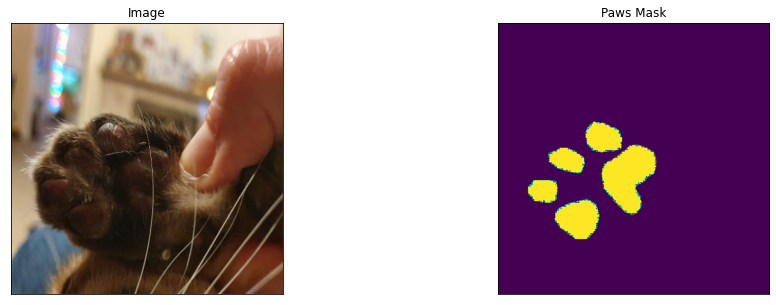

In [6]:
# Lets look at data we have

dataset = Dataset("", "", classes=['paw'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    paws_mask=mask.squeeze(),
)

In [7]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.2),

        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=90, shift_limit=0.2, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.3),
        albu.IAAPerspective(p=0.3),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.3,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.3,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albument

171
171


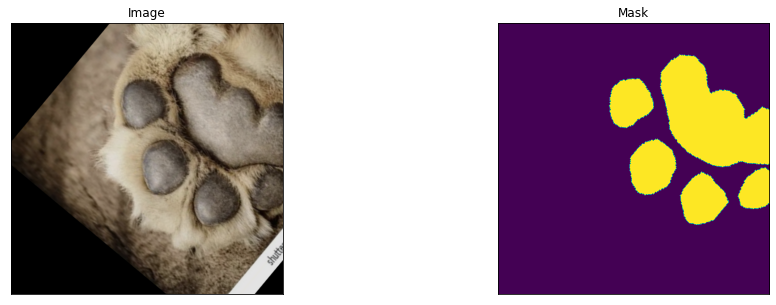

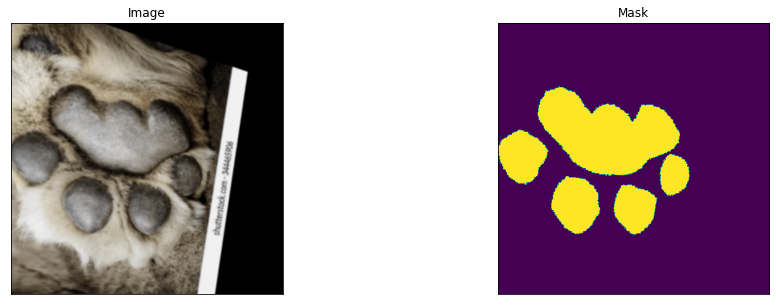

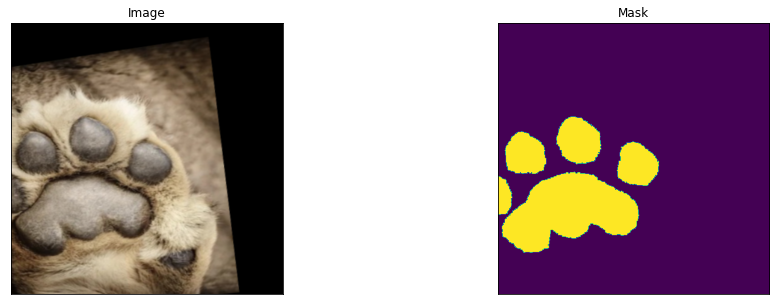

In [8]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    "", 
    "", 
    augmentation=get_training_augmentation(), 
    classes=['paw'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [9]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['paw']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
train_dataset = Dataset(
    "", 
    "", 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    "", 
    "", 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

171
171
171
171


In [12]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [13]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
# train model for 40 epochs

max_score = 0

for i in range(0, 30):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                              | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train: 100%|█| 6/6 [00:08<00:00,  1.46s/it, dice_loss - 0.7157, iou_score - 0.17
valid: 100%|█| 171/171 [00:06<00:00, 24.92it/s, dice_loss - 0.6117, iou_score - 
Model saved!

Epoch: 1
train: 100%|█| 6/6 [00:07<00:00,  1.23s/it, dice_loss - 0.5009, iou_score - 0.34
valid: 100%|█| 171/171 [00:06<00:00, 26.36it/s, dice_loss - 0.4677, iou_score - 
Model saved!

Epoch: 2
train: 100%|█| 6/6 [00:07<00:00,  1.22s/it, dice_loss - 0.3946, iou_score - 0.43
valid: 100%|█| 171/171 [00:06<00:00, 25.59it/s, dice_loss - 0.4437, iou_score - 
Model saved!

Epoch: 3
train: 100%|█| 6/6 [00:07<00:00,  1.27s/it, dice_loss - 0.3496, iou_score - 0.48
valid: 100%|█| 171/171 [00:06<00:00, 25.52it/s, dice_loss - 0.3809, iou_score - 
Model saved!

Epoch: 4
train: 100%|█| 6/6 [00:07<00:00,  1.23s/it, dice_loss - 0.3175, iou_score - 0.52
valid: 100%|█| 171/171 [00:07<00:00, 23.74it/s, dice_loss - 0.355, iou_score - 0
Model saved!

Epoch: 5
train: 100%|█| 6/6 [00:07<00:00,  1.25s/it, dice_loss - 0.2803, iou_score -

In [15]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [23]:
import numpy as np


def preprocess_input_smp(
    x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs
):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

In [21]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x7fdda57dca70>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

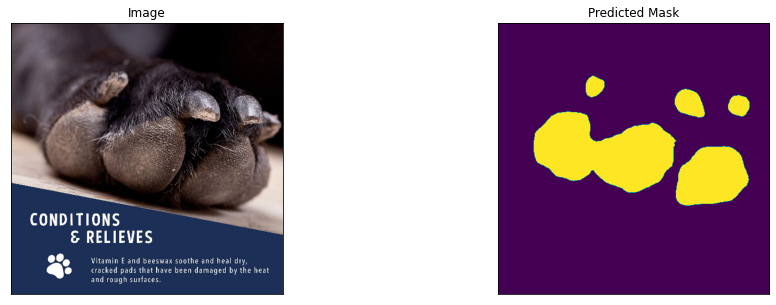

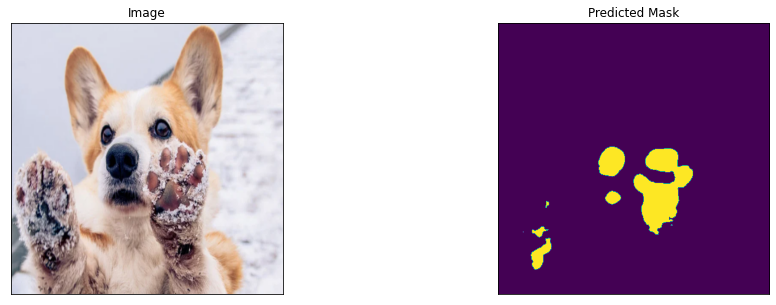

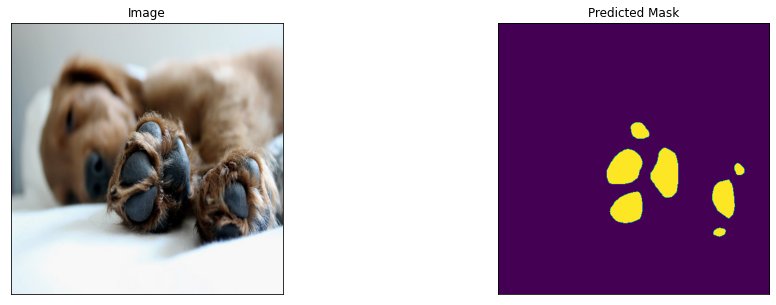

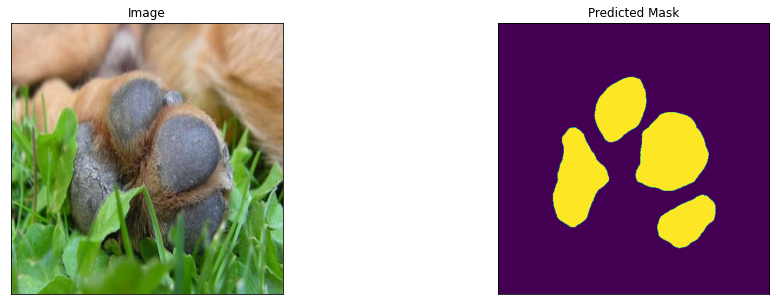

In [24]:
# visualize predictions on unseen, unlabeled images
for img in glob.glob("hard_tests/*.jpg"):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (480, 480))
    
    image_vis = image.astype('uint8')
    
    image = preprocess_input_smp(image, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = to_tensor(image)

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        predicted_mask=pr_mask
    )